# One-shot one-step LSTM Model on Cascadia
Author: Camilla Billari <br> 
Date: 27/01/24

Fitting a one-shot multi-step LSTM to the Cascadia dataset.

In [1]:
# Import relevant libraries
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm

# Change local path
MAIN_DICT = "/gws/nopw/j04/ai4er/users/cgbill/earthquake-predictability"
sys.path.append(MAIN_DICT)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset

In [2]:
# Check if CUDA (NVIDIA GPU acceleration) is available
if torch.cuda.is_available():
    dev, map_location = "cuda", None  # Use GPU
    print(
        f"Total GPUs available: {torch.cuda.device_count()}"
    )  # Display GPU count
    !nvidia-smi  # Display GPU details using nvidia-smi
else:
    dev, map_location = "cpu", "cpu"  # Use CPU
    print("No GPU available.")

# Set PyTorch device based on the chosen device (cuda or cpu)
device = torch.device(dev)

No GPU available.


## Load Data

In [3]:
# Access Cascadia and output dataframe head - need to ask Pritt about his loader
EXP = "cascadia"
dataset = SlowEarthquakeDataset([EXP])

ds_exp = dataset["cascadia"]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

df.head()

,seg_avg,seg_0,seg_1,seg_2,seg_3,seg_4,seg_5,seg_6,seg_7,seg_8,...,seg_187,seg_188,seg_189,seg_190,seg_191,seg_192,seg_193,seg_194,seg_195,time
0,1.510314e+08,87022.678176,-51216.196044,-195371.505863,-252388.298108,372090.056832,290238.755195,271991.646241,218795.685053,87096.609524,...,-714770.112748,-631423.743396,-693599.810348,-7.208255e+05,-739527.228854,-471014.225482,-6.757540e+05,-350155.612260,-517024.526987,2007.000700
1,1.256806e+08,118857.552212,64765.192887,-66943.170211,-125253.475061,510980.726973,375269.217942,323695.517273,312924.577753,-6911.497818,...,-506075.873333,-448764.275644,-391456.474306,-9.886575e+05,-958004.348328,-740390.446945,-8.927657e+05,-466337.939160,-928475.702850,2007.003438
2,1.074901e+08,-113120.619296,-100329.909243,-117236.092138,-63257.566664,87699.655400,15131.208777,-22576.356489,-13975.055467,-177396.925200,...,-421853.932989,-333693.022748,-204519.903296,-7.137062e+05,-715494.785171,-542145.799983,-6.803446e+05,-366915.287037,-572674.592498,2007.006176
3,1.447256e+08,-51897.143096,-61146.543996,-108560.424295,-80686.019435,178525.612880,98101.791008,48849.079713,53199.150697,-139909.026614,...,-655215.504038,-473799.573780,-345621.989210,-9.187762e+05,-927868.499626,-679886.516377,-8.823582e+05,-474262.121982,-695698.483285,2007.008914
4,1.787377e+08,-60139.943735,-118351.239477,-228181.280629,-226276.200039,270908.204014,154758.192851,92016.023222,86065.362414,-174784.005040,...,-916992.338832,-753637.001609,-546489.401328,-1.036981e+06,-934869.092836,-938970.117667,-1.106399e+06,-800182.900760,-897332.083419,2007.011651


In [4]:
df = df.dropna(axis=1)

# 3883 samples, so no need for downsampling
print("N samples: {}".format(len(df)))

N samples: 3883


## Data Pre-processing

### Detrend the data

In [5]:
p = np.polyfit(t, df["seg_avg"], deg=1)
segment_avg = df["seg_avg"] - (p[0] * t + p[1])

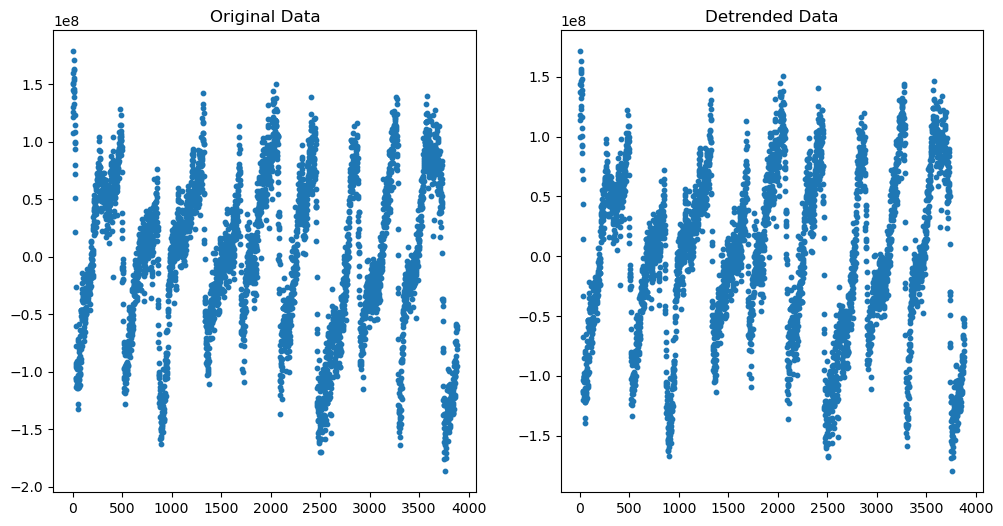

In [6]:
# Plot timeseries before and after downsampling
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(df)), df["seg_avg"], label="Original Data", s=10)
plt.title("Original Data")

plt.subplot(1, 2, 2)
plt.scatter(range(len(segment_avg)), segment_avg, label="Detrended Data", s=10)
plt.title("Detrended Data")

plt.show()

### Denoising

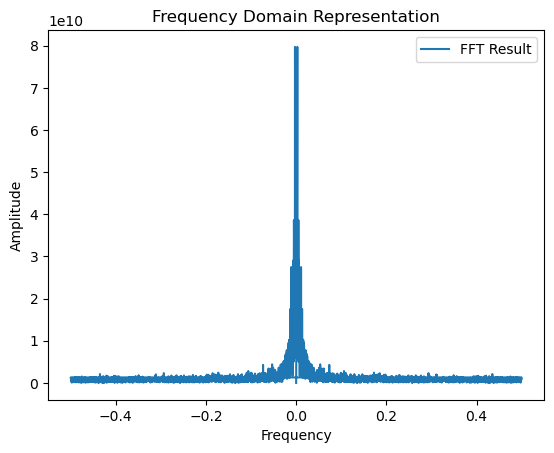

In [7]:
# First obtain a Fourier Transform of the signal to decide on cut-off frequency of the low pass filter
time = range(len(segment_avg))

# Perform FFT
fft_result = np.fft.fft(segment_avg)
frequencies = np.fft.fftfreq(len(time), time[1] - time[0])

# Plot the original signal and its frequency domain representation
plt.plot(frequencies, np.abs(fft_result), label="FFT Result")
plt.title("Frequency Domain Representation")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [8]:
from scipy.signal import butter, filtfilt

# Filter requirements.
T = 3883  # Sample Period
fs = 1  # sample rate, Hz
cutoff = (
    0.1  # desired cutoff frequency of the filter, Hz, based on the FFT above
)
nyq = 0.5 * fs  # Nyquist Frequency
order = 2  # sin wave can be approx represented as quadratic
n = int(T * fs)  # total number of samples

In [9]:
def butter_lowpass_filter(data, cutoff, order):
    normal_cutoff = cutoff / nyq

    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    y = filtfilt(b, a, data)
    return y

3883 3883


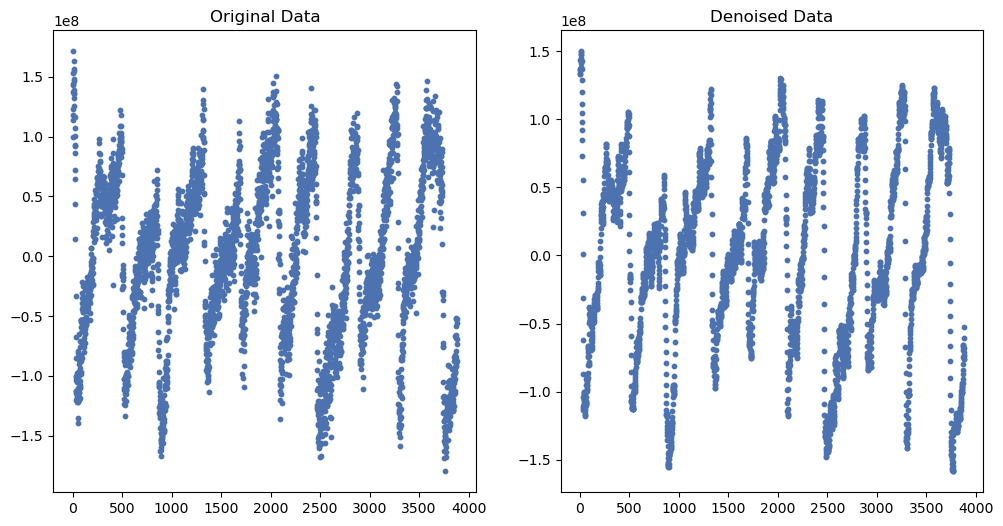

In [25]:
# Filter the data, and plot both the original and filtered signals.
denoised_df = butter_lowpass_filter(segment_avg, cutoff, order)
print(len(denoised_df), len(segment_avg))

# Plot timeseries before and after low-pass filtering
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(segment_avg)), segment_avg, label="Original Data", s=10)
plt.title("Original Data")

plt.subplot(1, 2, 2)
plt.scatter(range(len(denoised_df)), denoised_df, label="Denoised Data", s=10)
plt.title("Denoised Data")

plt.show()

## Creating the datastet

In [11]:
# Extract time series data
timeseries = denoised_df

# Define train-test split proportions
train_size = int(len(timeseries) * 0.75)
test_size = len(timeseries) - train_size

# Perform train-test split
train, test = timeseries[:train_size], timeseries[train_size:]

In [12]:
def create_dataset(dataset, lookback, forecast):
    """Transform a time series into a prediction dataset

    Args:
        dataset: Numpy array of time series (first dimension is the time steps).
        lookback: Size of the window for prediction.
        forecast: Number of time steps to predict into the future.
    Return:
        X_tensor: Pytorch tensor of the X windowed features
        y_tensor: Pytorch tensor of the y windowed targets
    """
    X, y = [], []

    # Create input features (X) and corresponding targets (y) for prediction
    for i in range(len(dataset) - lookback - forecast + 1):
        feature = dataset[i : i + lookback]
        target = dataset[i + lookback : i + lookback + forecast]
        X.append(feature)
        y.append(target)

    # Convert the lists to PyTorch tensors - note list->arrays->tensors is faster than list->tensors
    return torch.from_numpy(np.array(X, dtype=np.float32)), torch.from_numpy(
        np.array(y, dtype=np.float32)
    )

In [13]:
# Define lookback and forecast values
LOOKBACK, FORECAST = 60, 30

# Create training and testing dataset
X_train, y_train = create_dataset(train, LOOKBACK, FORECAST)
X_test, y_test = create_dataset(test, LOOKBACK, FORECAST)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([2823, 60]), torch.Size([2823, 30])
Testing data shapes: torch.Size([882, 60]), torch.Size([882, 30])


### Normalising with scaler based on the training set

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Note - we should only fit the scaler to the training set, not the test set!! Super important
# We only transform the test set, and we will then do an inverse transform later when evaluating.
X_train_sc, X_test_sc = scaler_X.fit_transform(X_train), scaler_X.transform(
    X_test
)
y_train_sc, y_test_sc = scaler_y.fit_transform(y_train), scaler_y.transform(
    y_test
)

# Turn all scaled arrays into float tensors
X_train_sc, X_test_sc = (
    torch.from_numpy(X_train_sc).float(),
    torch.from_numpy(X_test_sc).float(),
)
y_train_sc, y_test_sc = (
    torch.from_numpy(y_train_sc).float(),
    torch.from_numpy(y_test_sc).float(),
)

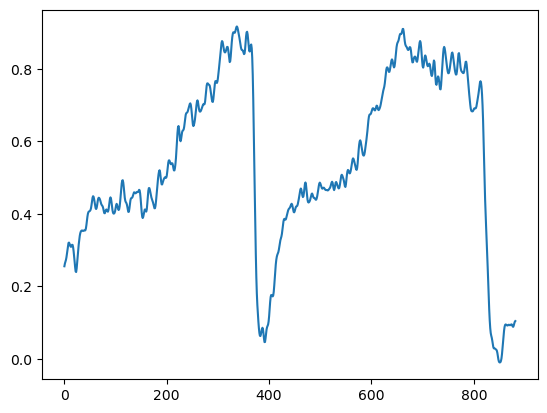

In [15]:
# Plot 3rd X_test window
plt.plot(X_test_sc[:, 2])

## Modelling

In [16]:
import torch.nn as nn


class MultiStepLSTM(nn.Module):
    """Subclass of nn.Module"""

    def __init__(
        self, n_variates=1, hidden_size=50, n_layers=1, output_size=FORECAST
    ):
        super().__init__()
        self.n_variates = n_variates
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.output_size = output_size

        # LSTM layer with specified input size, hidden size, and batch_first
        self.lstm = nn.LSTM(
            input_size=self.n_variates,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,
        )

        # Linear layer mapping the LSTM output to the forecasted values
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        """Forward pass through the LSTM layer."""
        # Initialise hidden state and cell state
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)

        # LSTM layer
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Extract the last time step output from the LSTM output
        lstm_out = lstm_out[:, -1, :]

        # Linear layer for the final output (forecasted values)
        output = self.linear(lstm_out)

        return output

### Training

In [17]:
# Move training and testing data to the specified device (cuda or cpu)
X_train_sc = X_train_sc.to(device)
y_train_sc = y_train_sc.to(device)
X_test_sc = X_test_sc.to(device)
y_test_sc = y_test_sc.to(device)

In [29]:
import torch.optim as optim
import torch.utils.data as data

# Define the number of input variates and hidden size
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST

# Instantiate the AirModel and move it to the specified device
model = MultiStepLSTM(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE).to(
    device
)

# Define Adam optimizer and Mean Squared Error (MSE) loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

# Create a DataLoader for training batches
loader = data.DataLoader(
    data.TensorDataset(X_train_sc, y_train_sc), shuffle=True, batch_size=32
)

# Set the number of training epochs
n_epochs = 200
pbar = tqdm.tqdm(range(n_epochs))

# Lists to store RMSE values for plotting
train_rmse_list = []
test_rmse_list = []
loss_batch_list = []

# Training loop
for epoch in pbar:
    model.train()

    # Iterate through batches in the DataLoader
    for X_batch, y_batch in loader:
        # Reshape input for univariate (add a dimension) and model
        y_pred = model(X_batch.unsqueeze(-1))
        loss = loss_fn(y_pred, y_batch)

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():  # do not consider gradient in evaluating - no backprop
        # Evaluate model on training data
        y_train_pred = model(X_train_sc.unsqueeze(-1))
        y_train_pred_inv = torch.Tensor(
            scaler_y.inverse_transform(y_train_pred.cpu())
        )
        train_rmse = np.sqrt(loss_fn(y_train_pred, y_train_sc))
        train_rmse_list.append(train_rmse.item())

        # Evaluate model on testing data
        y_test_pred = model(X_test_sc.unsqueeze(-1))
        y_test_pred_inv = torch.Tensor(
            scaler_y.inverse_transform(y_test_pred.cpu())
        )
        test_rmse = np.sqrt(loss_fn(y_test_pred, y_test_sc))
        test_rmse_list.append(test_rmse.item())

    # Update progress bar with training and testing RMSE
    pbar.set_description(
        f"Epoch [{epoch+1}/{n_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}"
    )

Epoch [200/200], Train RMSE: 0.0704, Test RMSE: 0.1674: 100%|██████████| 200/200 [01:17<00:00,  2.58it/s]


## Results

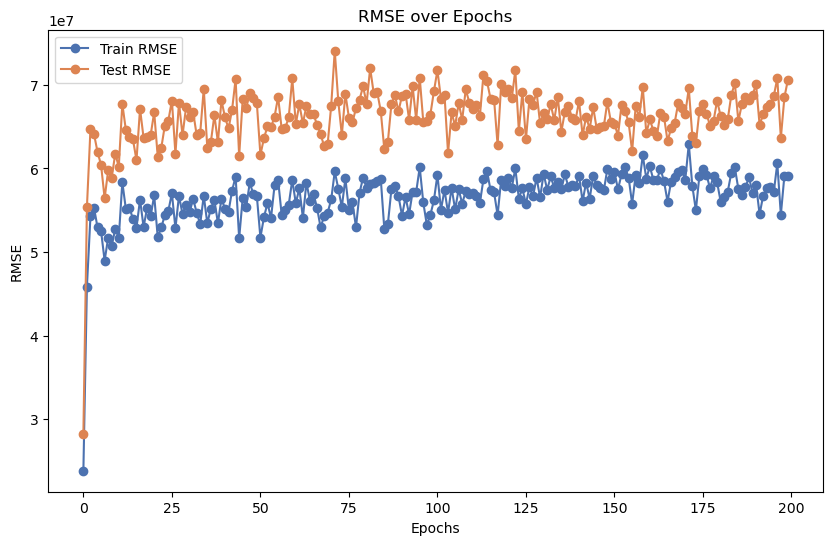

In [26]:
# Plot RMSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(0, n_epochs), train_rmse_list, label="Train RMSE", marker="o")
plt.plot(range(0, n_epochs), test_rmse_list, label="Test RMSE", marker="o")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs")
plt.legend()
plt.show()

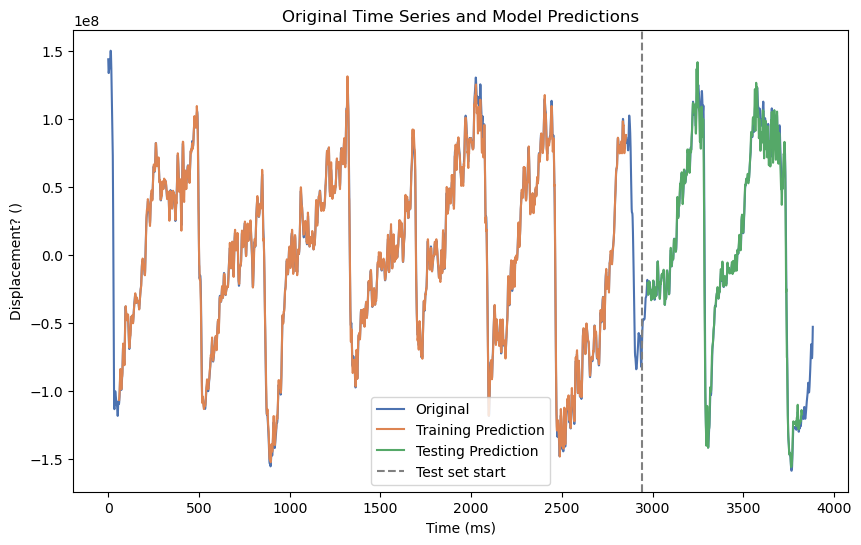

In [30]:
# TODO: CHECK WHY IT ISN'T PLOTTING END OF TRAIN AND TEST
import seaborn as sns

# Set a seaborn color palette for better color choices
sns.set_palette("deep")

with torch.no_grad():
    # Get predictions for training data and fill the plot array
    train_pred = model(X_train_sc.unsqueeze(-1))
    train_pred = scaler_y.inverse_transform(train_pred.cpu()).reshape(-1)

    # Get predictions for testing data and fill the plot array
    test_pred = model(X_test_sc.unsqueeze(-1))
    test_pred = scaler_y.inverse_transform(test_pred.cpu()).reshape(-1)

# Determine the starting index for the testing data
test_start_idx = len(timeseries) - len(y_test) - LOOKBACK

# Extract every forecast-th element and adjust length
idx = np.arange(0, len(timeseries), FORECAST)
train_outputs = np.array(
    [train_pred[idx] for idx in range(0, len(train_pred), FORECAST)]
)
test_outputs = np.array(
    [test_pred[idx] for idx in range(0, len(test_pred), FORECAST)]
)

# Create a NaN arrays to shift the plots
train_shift = np.full(LOOKBACK, np.nan)
test_shift = np.full(LOOKBACK - FORECAST + test_start_idx, np.nan)
train_plot = np.concatenate((train_shift, train_outputs))
test_plot = np.concatenate((test_shift, test_outputs))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(timeseries, label="Original")
plt.plot(train_plot, label="Training Prediction")
plt.plot(test_plot, label="Testing Prediction")
plt.axvline(
    x=test_start_idx, color="gray", linestyle="--", label="Test set start"
)
plt.title("Original Time Series and Model Predictions")
plt.xlabel("Time (ms)")
plt.ylabel("Displacement? ()")
plt.legend()
plt.show()